In [1]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2

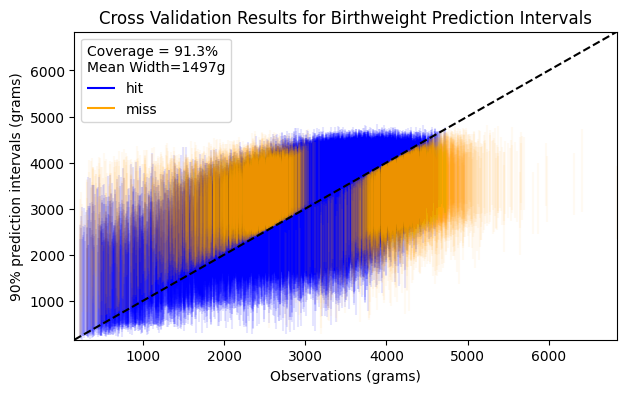

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

LOCAL_DIR = "~/dev/data/kaggle-prediction-interval-birthweight/"

train_data = pd.read_csv(LOCAL_DIR + "train.csv")[["id", "DBWT"]]
ehist_fitted = pd.read_csv(LOCAL_DIR + "fitted_HistBoostEnsembler.csv")
ehist_fitted = ehist_fitted.merge(train_data, on="id", how="inner", validate="1:1")
obs = ehist_fitted["DBWT"].values
lower = ehist_fitted["lower_HistBoostEnsembler"].values
upper = ehist_fitted["upper_HistBoostEnsembler"].values
hit_indicator = (obs >= lower) & (obs <= upper)

fig, ax = plt.subplots(1, 1, figsize=(7, 4))
ax.vlines(
    x=obs[hit_indicator],
    ymin=lower[hit_indicator],
    ymax=upper[hit_indicator],
    alpha=0.1,
    color="blue",
    label="hit",
)
ax.vlines(
    x=obs[~hit_indicator],
    ymin=lower[~hit_indicator],
    ymax=upper[~hit_indicator],
    alpha=0.05,
    color="orange",
    label="miss",
)
ax.set_xlim(np.min(np.concatenate([obs, lower])), np.max(np.concatenate([obs, upper])))
ax.set_ylim(np.min(np.concatenate([obs, lower])), np.max(np.concatenate([obs, upper])))
ax.plot([0, 1], [0, 1], transform=ax.transAxes, color="black", linestyle="dashed")
ax.set_xlabel("Observations (grams)")
ax.set_ylabel("90% prediction intervals (grams)")
legend = ax.legend(
    title=f"Coverage = {hit_indicator.mean() * 100:.1f}%\nMean Width={(upper - lower).mean():.0f}g"
)
for lh in legend.legend_handles:
    lh.set_alpha(1)
legend._legend_box.align = "left"
ax.set_title("Cross Validation Results for Birthweight Prediction Intervals")
plt.savefig("../cv_results.png", bbox_inches="tight")

In [3]:
# data = pd.read_csv("~/dev/data/kaggle-prediction-interval-birthweight/train.csv")
# data_test = pd.read_csv("~/dev/data/kaggle-prediction-interval-birthweight/test.csv")

# data_processor = DataProcessor(MODEL_TYPE)
# X, y = data_processor(data)

In [4]:
# tuner = WildWoodTuner(verbose=True)
# tuner.tune(X, y)
# tuner.result

In [5]:
# for which_param in range(2):
#     x = [i[which_param] for i in tuner.res_gp.x_iters]
#     plt.scatter(x, tuner.res_gp.func_vals)
#     plt.show()

In [6]:
# def plot_result(obs, lower, upper, lower_new, upper_new):
#     fig, ax = plt.subplots(1, 3, figsize=(10, 3))
#     ax[0].vlines(x=obs, ymin=lower, ymax=upper, alpha=0.25)
#     ax[0].set_xlim(
#         np.min(np.concatenate([obs, lower])), np.max(np.concatenate([obs, upper]))
#     )
#     ax[0].set_ylim(
#         np.min(np.concatenate([obs, lower])), np.max(np.concatenate([obs, upper]))
#     )
#     ax[0].plot([0, 1], [0, 1], transform=ax[0].transAxes, color="orange")
#     ax[0].set_xlabel("observations")
#     ax[0].set_ylabel("predictions")
#     ax[1].hist(lower, bins=100, density=True, color="blue", alpha=0.75, label="train")
#     ax[1].hist(
#         lower_new, bins=100, density=True, color="orange", alpha=0.75, label="test"
#     )
#     ax[1].set_xlabel("predicted lower bounds")
#     ax[1].legend()
#     ax[2].hist(upper, bins=100, density=True, color="blue", alpha=0.75, label="train")
#     ax[2].hist(
#         upper_new, bins=100, density=True, color="orange", alpha=0.75, label="test"
#     )
#     ax[2].set_xlabel("predicted upper bounds")
#     ax[2].legend()
#     plt.show()


# validator = Validator(MODEL_TYPE)
# validator.fit(data)
# validator.print_performance_summary()

# lower, upper = validator.predict_intervals(data)
# lower_new, upper_new = validator.predict_intervals(data_test)

# plot_result(data["DBWT"], lower, upper, lower_new, upper_new)